[Source at Rosetta Code](https://rosettacode.org/wiki/A*_search_algorithm#Python)

In [3]:
mypolars={ 6:[0.315679931593773,	-5.11963598638016,	34.2073561957758,	-121.695198238111,	248.489879048305, \
                -290.644183172735,	176.372420712742,	-34.0123838853998,	-2.16034293014928],
8:[0.0238604376817297,	-0.567721437819886,	4.07062500047844,	-11.2940636816077,	4.11965019586976,	43.6666758062587, \
   -99.7920563994945,	92.466538852542,	-25.6480289006842],
10:[-0.0591241174313379,	0.380032419176075,	0.342894143767638,	-7.55209469474344,	17.5946838478113, \
    -1.24634408220442,	-46.3390695103949,	63.9918649480057,	-19.1632945804615],
12:[-0.481916973640513,	7.60260153773329,	-51.7505967950519,	199.202079989257,	-475.182437672317, \
    719.164802893553,	-675.017774649225,	361.932657214902,	-77.0202204468818],
16:[0.0887857639696129,	-0.766710112052253,	-0.334816588305918,	27.3135355851111,	-135.151085559757, \
    313.676735642741,	-390.433451995094,	253.203172667432,	-58.6155260162626],
20:[-0.00579737621930548,	-0.0338403103021861,	-0.347056346202211,	10.3569732499987,	-62.9019494841648, \
    173.144263412207,	-245.571117560733,	176.57312725869,	-42.0001355117172],
24:[-1.63924336010598,	24.5126163155162,	-156.711881615492,	560.967952674478,	-1234.15058604918, \
    1714.29897021706,	-1471.25577756942,	715.945845392126,	-142.696823393666]}

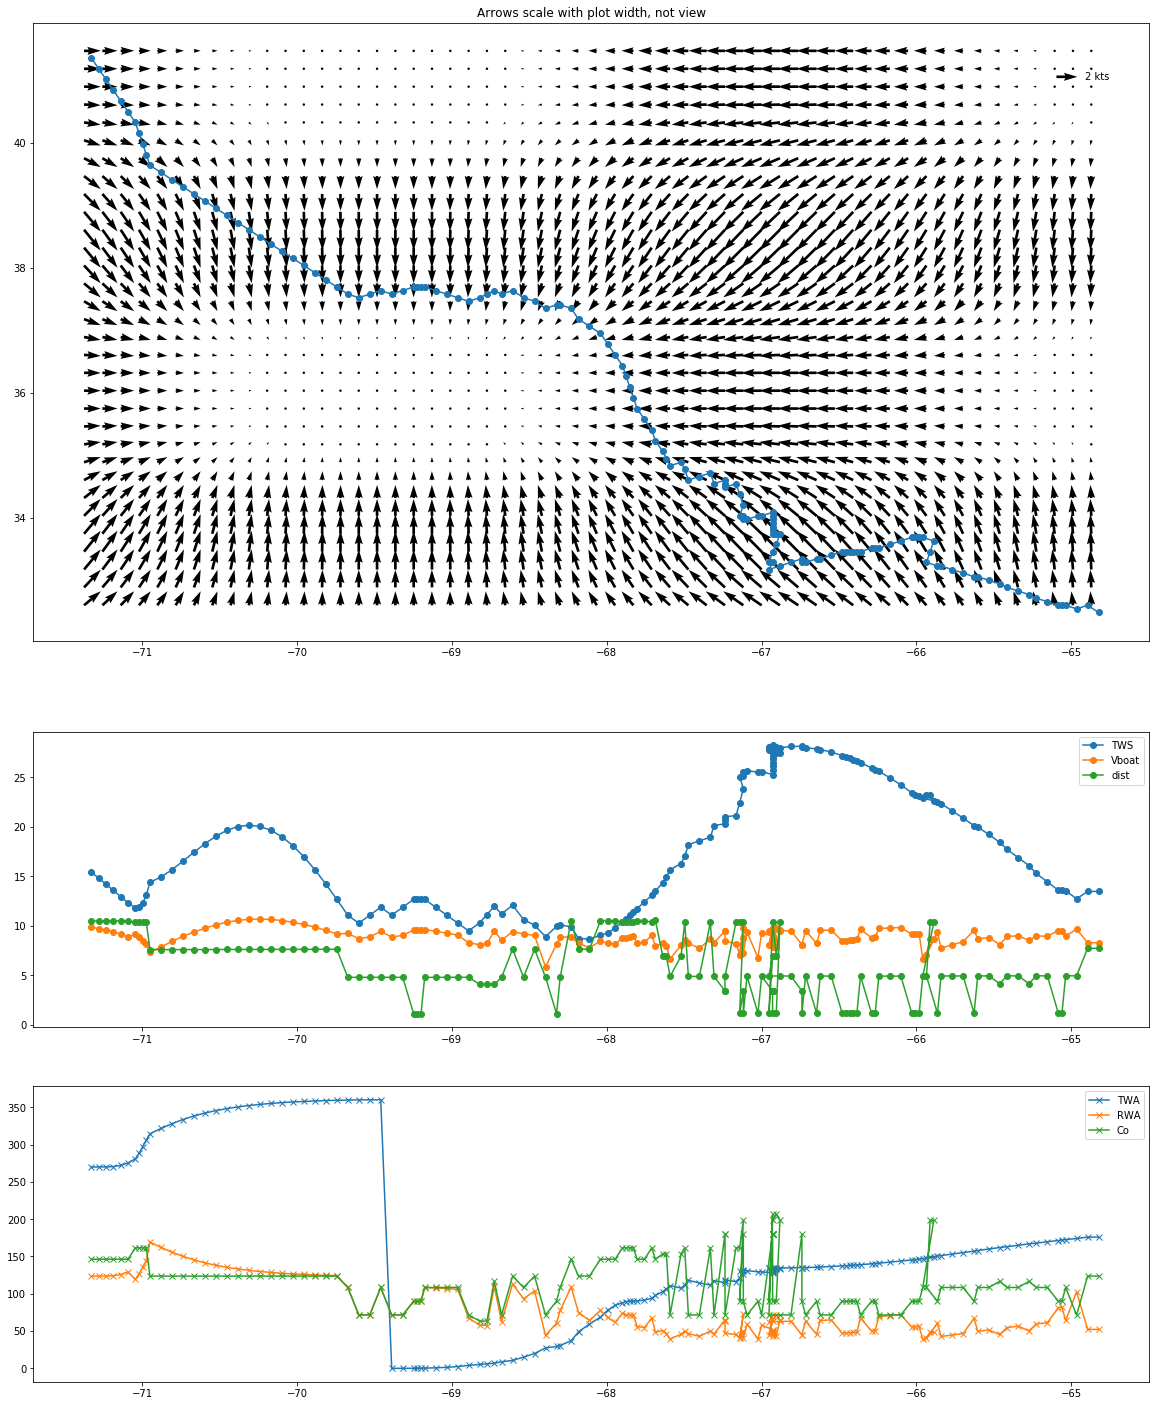

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from astar import AStar
import sys
import math
%matplotlib inline


def make_wind_map(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),scale=7.,windMult=1.):
    """returns an table of wind vectors in knots"""
    ##TODO - make 
    result = ('+' + '='*w + '+\n') + ('|' + ' '*w + '|\n')*h + ('+' + '='*w + '+')
    Y,X = np.meshgrid(np.arange(TopLeft[0], BottomRight[0],(BottomRight[0]-TopLeft[0])/w) , \
                       np.arange(TopLeft[1], BottomRight[1],(BottomRight[1]-TopLeft[1])/h))
    U = np.cos(X*scale*np.pi/180.)
    V = np.sin(Y*scale*np.pi/180.)
    U = U * abs(U)**2
    V = V * abs(V)**2
    U=U*windMult
    V=V*windMult
    return {'text':result.strip(),'X':X,'Y':Y,'U':U,'V':V}

class PathSolver(AStar):
    """sample use of the astar algorithm. In this exemple we work on a maze made of ascii characters,
    and a 'node' is just a (x,y) tuple that represents a reachable position"""

    def __init__(self, windmap, polars,clamp_RWA=-99,H_average_speed=6,neighbor_range=2):
        self.polars_speeds = sorted(polars.keys())
        self.heuristic_average_speed=H_average_speed  #knots ==> speed used for cost estimates for unfinished
                                                      # part of the journey to the goal.
        self.polars_guts   = np.matrix([ polars[cha] for cha in self.polars_speeds])
#        self.lines = windmap['text'].strip().split('\n')
        self.width = windmap['U'].shape[0]
        self.height = windmap['U'].shape[1]
        self.windmap = windmap
        self.clamp_RWA=clamp_RWA
        #determins how far out a cell is considered a neighbor of a given cell.
        self.neigh=[(0,1),(0,-1),(-1,-1),(-1,0),(-1,1),(1,-1),(1,0),(1,1)]
        if neighbor_range>1:     #Default
            self.neigh.extend([(-2,1),(-2,-1),(-1,-2),(-1,2),(1,-2),(1,2),(2,-1),(2,1)])
        if neighbor_range>2:
            self.neigh.extend([(-3,2),(-3,1),(-3,-2),(-3,-1),(-2,-3),(-2,3),(-1,-3),(-1,3),(3,2),\
                               (3,1),(3,-2),(3,-1),(2,-3),(2,3),(1,-3),(1,3)])
        if neighbor_range>3:
            self.neigh.extend([(-4,-3),(-4,-2),(-4,-1),(-4,1),(-4,2),(-4,3),\
                               (4,-3),(4,-2),(4,-1),(4,1),(4,2),(4,3),\
                                (-3,-4),(-2,-4),(-1,-4),(1,-4),(2,-4),(3,-4),\
                               (-3,4),(-2,4),(-1,4),(1,4),(2,4),(3,4),])


    def plotPath(self, pathin, arrowSpacing=1):
        pathpoints=[(self.windmap['X'][pp[0],pp[1]],self.windmap['X'][pp[0],pp[1]],m['U'][pp[0],pp[1]],m['V'][pp[0],pp[1]]) for pp in pathin]
        plt.figure(figsize=(20,25))
        ax1=plt.subplot(211)
        
        plt.title('Arrows scale with plot width, not view')
        Q = plt.quiver(self.windmap['X'][::arrowSpacing,::arrowSpacing], self.windmap['Y'][::arrowSpacing,::arrowSpacing], \
                       self.windmap['U'][::arrowSpacing,::arrowSpacing], self.windmap['V'][::arrowSpacing,::arrowSpacing], units='width')
        qk = plt.quiverkey(Q, 0.85, 0.85, max(abs(self.windmap['U'].max()),abs(self.windmap['V'].max())), r'2 kts', labelpos='E', \
                           coordinates='figure')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[self.windmap['Y'][pp[0],pp[1]] for pp in pathin],'-o')
        boatdata=[self.get_LocationParameters(pathin[ppi],pathin[ppi+1],degrees=True) for ppi in range(len(pathin)-1)]
        boatdata.append(boatdata[-1])
        ax2=plt.subplot(413,sharex=ax1)
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[1] for pp in boatdata],'-o',label='TWS')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[5] for pp in boatdata],'-o',label='Vboat')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[0] for pp in boatdata],'-o',label='dist')
        plt.legend()
        ax2=plt.subplot(414,sharex=ax1)
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[2] for pp in boatdata],'-x',label='TWA')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[3] for pp in boatdata],'-x',label='RWA')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[4] for pp in boatdata],'-x',label='Co')
        plt.legend()
        return boatdata
        
    def unit_vector(self,vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    def angle_between(self,v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'::

                >>> angle_between((1, 0, 0), (0, 1, 0))
                1.5707963267948966
                >>> angle_between((1, 0, 0), (1, 0, 0))
                0.0
                >>> angle_between((1, 0, 0), (-1, 0, 0))
                3.141592653589793
        """
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    def speed_from_polars(self,RWA,TWS=6):
        if self.clamp_RWA>0 and RWA<self.clamp_RWA:
            result=-99
        else:
            order=self.polars_guts.shape[1]
            y=np.ones(order)
            for i in range(order-1,0,-1):
                y[i-1]=y[i]*RWA
            result_vec=(PS.polars_guts*np.matrix(y).transpose()).transpose().tolist()
            result=np.interp(TWS,[0.] + self.polars_speeds + [self.polars_speeds[-1]*3], \
                             [0.] + result_vec[0] + [result_vec[0][-1]],left=-99,right=-99)
        if result > 0:
            return result
        else:
            return 0.001

    def get_LocationParameters(self,n1,n2, gscore=0,degrees=False):

        #TODO ==> adjust wind speed based on gscore (time)
        #TODO ==> add Current lookup and speed
        (x1, y1) = n1
        (x2, y2) = n2
        (La1,Lo1) = (self.windmap['Y'][x1,y1],self.windmap['X'][x1,y1])
        (La2,Lo2) = (self.windmap['Y'][x2,y2],self.windmap['X'][x2,y2])
        wind=(-self.windmap['U'][x1,y1],-self.windmap['V'][x1,y1])
        boat_vector=(x2-x1,y1-y2)
        meanLat=(La1+La2)/2.
        TWS=math.hypot(wind[0],wind[1])
        #distance in nm
        dist=math.hypot((Lo2 - Lo1)*np.cos(meanLat*np.pi/180.), La2 - La1)*60.
        #print "Wind:",wind, " TWA:",(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
        #print "boat_vector:", boat_vector, " Boat Course:",
        if degrees:
            TWA=(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
            course=(np.arctan2(boat_vector[0],boat_vector[1])*180./np.pi+360)%360
        else:
            TWA=np.arctan2(wind[0],wind[1])
            course=np.arctan2(boat_vector[0],boat_vector[1])
        #print "boat_vector:", boat_vector, " Boat Course:",
        RWA=self.angle_between(wind,boat_vector)
        #print "Relative True Wind Angle:",ang*180/np.pi
        BoatSpeed=self.speed_from_polars(RWA,TWS)
        #print "Boat Speed: ", BoatSpeed
        if degrees:
            RWA=RWA*180/np.pi
        return dist,TWS,TWA,RWA,course,BoatSpeed
    
#### Below are the standard A-Star Functions
    def heuristic_cost_estimate(self, n1, n2, gscore=0):
        """computes the time to travel 'direct' distance between two (x,y) tuples"""
        #TODO ==> use smarter heuristic based on 
        (x1, y1) = n1
        (x2, y2) = n2
        (La1,Lo1) = (self.windmap['Y'][x1,y1],self.windmap['X'][x1,y1])
        (La2,Lo2) = (self.windmap['Y'][x2,y2],self.windmap['X'][x2,y2])
        meanLat=(La1+La2)/2.
        dist=math.hypot((Lo2 - Lo1)*np.cos(meanLat*np.pi/180.), La2 - La1)*60./self.heuristic_average_speed
        return dist

    def distance_between(self, n1, n2, gscore=0):
        """this method returns the time to travel into a neighbor's cell based on conditions in the current cell"""
        # We're cheating a bit as some of the neighbors aren't exactly adjacent but we're 
        # assuming the prevailing local conditions are such that it doesn't matter 
        dist,TWS,TWA,RWA,course,BoatSpeed = self.get_LocationParameters(n1,n2,gscore)
        #cost is distance/speed
        return dist / BoatSpeed

    def neighbors(self, node):
        """ for a given coordinate in the maze, returns up to adjacent
            nodes that can be reached 
        """
        x, y = node
        return[(nx, ny) for nx, ny in [(x+xx,y+yy) for xx,yy in self.neigh] if 0 <= nx < self.width and \
               0 <= ny < self.height ]

size = 200
# what is the size of it?
w = 160
h = 280
m = make_wind_map(w,h,scale=35,windMult=20.)

# table of 8th order Polinomials representing boat speed vs TWA
# 1st term is X^8 last term is X^0
#

Lowest_RelativeWindAngle=38. 

PS=PathSolver(m,mypolars,Lowest_RelativeWindAngle*np.pi/180,neighbor_range=3)

start = (2, 2)  # we choose to start at the upper left corner
goal = (h - 3,w - 3)  # we want to reach the lower right corner

# let's solve it
foundPath = list(PS.astar(start, goal))
# print the solution
pPPS=PS.plotPath(foundPath,arrowSpacing=5)
#print pPPS

In [44]:
np.interp(2.5, m['X'][:,1])

-71.31577232142857

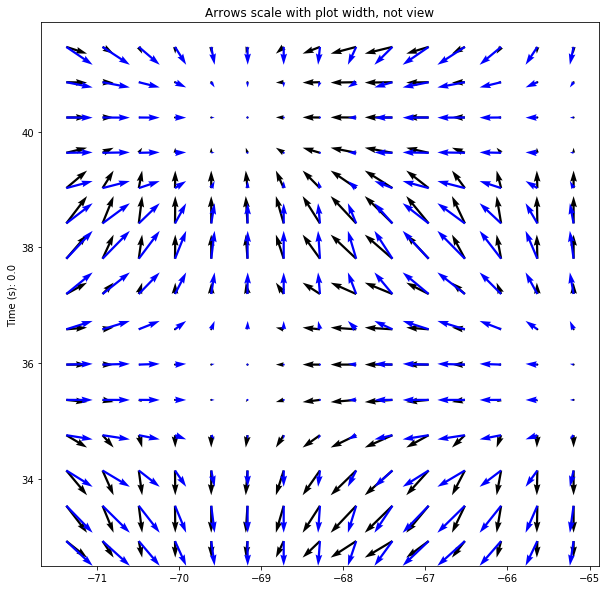

In [9]:
#
#  https://brushingupscience.wordpress.com/2016/06/21/matplotlib-animations-the-easy-way/
#

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy import ma
from astar import AStar
import sys
import math
#%matplotlib inline

def make_wind_map_mega(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),timescales=[(0.,7.)],windMult=1.):
    """returns an table of wind vectors in knots vs time"""
    Y,X,T = np.meshgrid(np.arange(TopLeft[0], BottomRight[0],(BottomRight[0]-TopLeft[0])/w) , \
                       np.arange(TopLeft[1], BottomRight[1],(BottomRight[1]-TopLeft[1])/h) , \
                       [tt[1] for tt in timescales])
    if False:
        for tim,scale in timescales:
            Uu = np.cos(X*scale*np.pi/180.)
            Vv = np.sin(Y*scale*np.pi/180.)
            Uu = Uu * abs(Uu)**2
            Vv = Vv * abs(Vv)**2
            Uu=Uu*windMult
            Vv=Vv*windMult
            U.append(Uu)
            V.append(Vv)
    Uu = np.cos(X*T*np.pi/180.)
    Vv = np.sin(Y*T*np.pi/180.)
    U = Uu * abs(Uu)**2 * windMult
    V = Vv * abs(Vv)**2 * windMult
    return {'X':X[...,0],'Y':Y[...,0],'U':U,'V':V,'T':timescales}


Steps=80
MaxTime=10.
ScaleGrowth=1.
timescales=zip(np.linspace(0.,MaxTime,Steps),np.linspace(40.,40.+ScaleGrowth,Steps))
#print timescales
m=make_wind_map_mega(timescales=timescales)
arrowSpacing=2
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10, 10))

#ax1=plt.subplot(211)
plt.title('Arrows scale with plot width, not view')
step=0
#cmap = plt.cm.jet
qax = ax.quiver(m['X'][::arrowSpacing,::arrowSpacing], m['Y'][::arrowSpacing,::arrowSpacing], \
               m['U'][::arrowSpacing,::arrowSpacing,step], m['V'][::arrowSpacing,::arrowSpacing,step] \
               ,units='width',scale=20)

qax2 = ax.quiver(m['X'][::arrowSpacing,::arrowSpacing], m['Y'][::arrowSpacing,::arrowSpacing], \
               m['U'][::arrowSpacing,::arrowSpacing,step+Steps/2], m['V'][::arrowSpacing,::arrowSpacing,step+Steps/2] \
               ,color='blue',units='width',scale=20)

def animate(i):
    qax.set_UVC(m['U'][::arrowSpacing,::arrowSpacing,i], m['V'][::arrowSpacing,::arrowSpacing,i])
    qax2.set_UVC(m['U'][::arrowSpacing,::arrowSpacing,(i+Steps/2)%Steps], m['V'][::arrowSpacing,::arrowSpacing,(i+Steps/2)%Steps])
    #qax.set_color(cmap(30+i*20))
    ax.set_ylabel('Time (s): ' + str(int(timescales[i][0]*1000)/1000.))
    
anim = FuncAnimation(
    fig, animate, interval=150, frames=len(timescales)-1)
 
plt.draw()
plt.show()

anim.save('allwinds.mp4')



In [ ]:
m['U'][1,1,3]*0.

In [ ]:
from math import floor
def sign(n):
    return (n > 0) - (n < 0)

def raytrace(A, B):
    """ Return all cells of the unit grid crossed by the line segment between
        A and B.
    """

    (xA, yA) = A
    (xB, yB) = B
    (dx, dy) = (xB - xA, yB - yA)
    (sx, sy) = (sign(dx), sign(dy))

    grid_A = (floor(A[0]), floor(A[1]))
    grid_B = (floor(B[0]), floor(B[1]))
    (x, y) = grid_A
    traversed=[grid_A]

    tIx = dy * (x + sx - xA) if dx != 0 else float("+inf")
    tIy = dx * (y + sy - yA) if dy != 0 else float("+inf")

    while (x,y) != grid_B:
        # NB if tIx == tIy we increment both x and y
        (movx, movy) = (tIx <= tIy, tIy <= tIx)

        if movx:
            # intersection is at (x + sx, yA + tIx / dx^2)
            x += sx
            tIx = dy * (x + sx - xA)

        if movy:
            # intersection is at (xA + tIy / dy^2, y + sy)
            y += sy
            tIy = dx * (y + sy - yA)

        traversed.append( (x,y) )

    return traversed

raytrace((1.,2.),(10.,10.))

In [55]:
from math import floor
def line(A,B,width=1,span=False,skiplast=False):   #,x0), y0, x1, y1):
    "Bresenham's line algorithm"
    #TODO - pick a better way of doing this.
    (x0,y0)=A
    (x1,y1)=B
    result={}
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sqdxdy=(dx**2+dy**2)**0.5 if width>1 else 1.
    if sqdxdy<1:
        return []
    else:
        x, y = x0, y0
        sx = -1 if x0 > x1 else 1
        sy = -1 if y0 > y1 else 1
        pdy=+width/2.*dy*sy/sqdxdy
        pdx=+width/2.*dx*sx/sqdxdy
        cnt=0
        if width>1:
            near=line((floor(x0+pdy),floor(y0-pdx)),(floor(x0-pdy),floor(y0+pdx)),width=1)
            far=line((floor(x1+pdy),floor(y1-pdx)),(floor(x1-pdy),floor(y1+pdx)),width=1)
            interim=[]
            zipped=zip(near,far)
            for A1,B1 in zipped:
                interim.append(line(A1,B1,width=1))
            for point in [item for sublist in map(list, zip(*interim)) for item in sublist]:
                result[point]=cnt
                cnt+=1
        else:
            if dx > dy:
                err = dx / 2.0
                while x != x1:
                    result[(int(x), int(y))]=cnt
                    cnt+=1
                    err -= dy
                    if err < 0:
                        y += sy
                        err += dx
                    x += sx
            else:
                err = dy / 2.0
                while y != y1:
                    result[(int(x), int(y))]=cnt
                    cnt+=1
                    err -= dx
                    if err < 0:
                        x += sx
                        err += dy
                    y += sy        
            result[(int(x), int(y))]=cnt
            cnt+=1
        FinalResult=[key for key, value in sorted(result.iteritems(), key=lambda (k,v): (v,k))]
        if skiplast:
            FinalResult.pop()
        return FinalResult

AAA=line((2,2),(20,20),skiplast=True)
print len(AAA),AAA
[X*Y for X,Y in AAA ]




18 [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19)]


[4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361]

In [45]:
foo=range(5)
print foo
foo.pop()
print foo

[0, 1, 2, 3, 4]
[0, 1, 2, 3]


In [49]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy import ma
from astar import AStar
import sys
import math
%matplotlib inline
fig=plt.figure()
AAA=line((-20,6),(20,-16),6)
plt.scatter(*zip(*AAA))

TypeError: zip argument #1 must support iteration

In [ ]:
foo=[[1,2,3,4]]
print foo
foo.append([4,5,23,4,5])
print foo

In [ ]:
A,B=(1,6),(9,3)
width=10
(x0,y0)=A
(x1,y1)=B
print A,B
result={}
dx = abs(x1 - x0)
dy = abs(y1 - y0)
sqdxdy=(dx**2+dy**2)**0.5 if width>1 else 1.
x, y = x0, y0
sx = -1 if x0 > x1 else 1
sy = -1 if y0 > y1 else 1
pdy=+width/2.*dy*sy/sqdxdy
pdx=+width/2.*dx*sx/sqdxdy
print x,y,sqdxdy
print "X",[ii for ii in [x-pdx,x+pdx,x-pdy,x+pdy]]
print "Y",[ii for ii in [y-pdx,y+pdx,y-pdy,y+pdy]]
print 

In [ ]:
print [(x+pdy,y-pdx),(x-pdy,y+pdx)]

In [ ]:
plt.figure(figsize=(10,10))

RWA = np.arange(0,np.pi,0.1)
#[(ii*180/np.pi,PS.speed_from_polars(ii,1.)) for ii in RWA]
for TWS in [1.,2.,3.,4.,6.,8.,10.,14.,18.,22.,26.]:
    plt.plot([ii*180/np.pi for ii in RWA],[PS.speed_from_polars(ii,TWS) for ii in RWA], '-o',label="TWS = %d"%TWS)
plt.legend()


In [ ]:
plt.plot(np.arange(0, 1.2*np.pi, .2),[PS.speed_from_polars(ii) for ii in np.arange(0, 1.2*np.pi, .2)])
plt.show()

In [ ]:
xp = [1, 2, 3]
fp = [3, 2, 0]
%timeit b=np.interp(2.5, xp, fp)
print np.interp([0, 1, 1.5, 2.72, 3.14], xp, fp)
UNDEF = -99.0
np.interp(3.14, xp, fp, right=UNDEF)

In [ ]:
# %load C:\Users\hillel\Apps\Continuum\Anaconda2\Lib\site-packages\astar\__init__.py
""" generic A-Star path searching algorithm """

from abc import ABCMeta, abstractmethod
from heapq import heappush, heappop

__author__ = "Julien Rialland"
__copyright__ = "Copyright 2012-2017, J.Rialland"
__license__ = "BSD"
__version__ = "0.9"
__maintainer__ = __author__
__email__ = "julien.rialland@gmail.com"
__status__ = "Production"

Infinite = float('inf')

class AStar:
    __metaclass__ = ABCMeta
    __slots__ = ()

    class SearchNode:
        __slots__ = ('data', 'gscore', 'fscore',
                     'closed', 'came_from', 'out_openset')

        def __init__(self, data, gscore=Infinite, fscore=Infinite):
            self.data = data
            self.gscore = gscore
            self.fscore = fscore
            self.closed = False
            self.out_openset = True
            self.came_from = None

        def __lt__(self, b):
            return self.fscore < b.fscore

    class SearchNodeDict(dict):

        def __missing__(self, k):
            v = AStar.SearchNode(k)
            self.__setitem__(k, v)
            return v

    @abstractmethod
    def heuristic_cost_estimate(self, current, goal, gscore=0):
        """Computes the estimated (rough) distance between a node and the goal, this method must be implemented in a subclass. The second parameter is always the goal."""
        raise NotImplementedError

    @abstractmethod
    def distance_between(self, n1, n2, gscore=0):
        """Gives the real distance between two adjacent nodes n1 and n2 (i.e n2 belongs to the list of n1's neighbors).
           n2 is guaranteed to belong to the list returned by the call to neighbors(n1).
           This method must be implemented in a subclass."""
        raise NotImplementedError

    @abstractmethod
    def neighbors(self, node):
        """For a given node, returns (or yields) the list of its neighbors. this method must be implemented in a subclass"""
        raise NotImplementedError

    def is_goal_reached(self, current, goal):
        """ returns true when we can consider that 'current' is the goal"""
        return current == goal

    def reconstruct_path(self, last, reversePath=False):
        def _gen():
            current = last
            while current:
                yield current.data
                current = current.came_from
        if reversePath:
            return _gen()
        else:
            return reversed(list(_gen()))

    def astar(self, start, goal, reversePath=False, gscore_based=False):
        if self.is_goal_reached(start, goal):
            return [start]
        searchNodes = AStar.SearchNodeDict()
        startNode = searchNodes[start] = AStar.SearchNode(
            start, gscore=.0, fscore=self.heuristic_cost_estimate(start, goal))
        openSet = []
        heappush(openSet, startNode)
        while openSet:
            current = heappop(openSet)
            if self.is_goal_reached(current.data, goal):
                return self.reconstruct_path(current, reversePath)
            current.out_openset = True
            current.closed = True
            for neighbor in [searchNodes[n] for n in self.neighbors(current.data)]:
                if neighbor.closed:
                    continue
                tentative_gscore = current.gscore + \
                    (self.distance_between(current.data, neighbor.data, current.gscore) if  gscore_based else \ 
                     self.distance_between(current.data, neighbor.data))
                if tentative_gscore >= neighbor.gscore:
                    continue
                neighbor.came_from = current
                neighbor.gscore = tentative_gscore
                neighbor.fscore = tentative_gscore + \
                    (self.heuristic_cost_estimate(neighbor.data, goal,neighbor.gscore) if gscore_based else \ 
                     self.heuristic_cost_estimate(neighbor.data, goal,neighbor.gscore))
                if neighbor.out_openset:
                    neighbor.out_openset = False
                    heappush(openSet, neighbor)
        return None


def find_path(start, goal, neighbors_fnct, reversePath=False, heuristic_cost_estimate_fnct=lambda a, b: Infinite, distance_between_fnct=lambda a, b: 1.0, is_goal_reached_fnct=lambda a, b: a == b):
    """A non-class version of the path finding algorithm"""
    class FindPath(AStar):
        def heuristic_cost_estimate(self, current, goal):
            return heuristic_cost_estimate_fnct(current, goal)
        def distance_between(self, n1, n2):
            return distance_between_fnct(n1, n2)
        def neighbors(self, node):
            return neighbors_fnct(node)
        def is_goal_reached(self, current, goal):
            return is_goal_reached_fnct(current, goal)
    return FindPath().astar(start, goal, reversePath)

__all__ = ['AStar', 'find_path']


In [ ]:
import numpy as np
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680811)


fig, ax = plt.subplots()

resolution = 50  # the number of vertices
N = 3
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r)
    patches.append(circle)

x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
theta1 = 360.0*np.random.rand(N)
theta2 = 360.0*np.random.rand(N)
for x1, y1, r, t1, t2 in zip(x, y, radii, theta1, theta2):
    wedge = Wedge((x1, y1), r, t1, t2)
    patches.append(wedge)

# Some limiting conditions on Wedge
patches += [
    Wedge((.3, .7), .1, 0, 360),             # Full circle
    Wedge((.7, .8), .2, 0, 360, width=0.05),  # Full ring
    Wedge((.8, .3), .2, 0, 45),              # Full sector
    Wedge((.8, .3), .2, 45, 90, width=0.10),  # Ring sector
]

for i in range(N):
    polygon = Polygon(np.random.rand(N, 2), True)
    patches.append(polygon)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
